# Chat Analysis Dashboard

This notebook provides comprehensive analysis and visualization of your processed AI chat conversations.

## Setup and Data Loading

In [2]:
import json
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Set up plotting styles
plt.style.use('default')
sns.set_palette("husl")

print("📊 Analysis libraries loaded successfully!")

📊 Analysis libraries loaded successfully!


In [3]:
# Environment/kernal guard and dependency bootstrap
import sys

EXPECTED_KERNEL_NAME = "chat_analysis_env"  # set to your venv name used for Jupyter
FORCE_EXPECTED_KERNEL = False  # set True to hard-stop if a different kernel is used

print("\n🧪 Environment check:")
print(f" • Python executable: {sys.executable}")
in_venv = (getattr(sys, 'base_prefix', sys.prefix) != sys.prefix) or hasattr(sys, 'real_prefix')
print(f" • In virtualenv: {in_venv}")

# Heuristic: check whether the current interpreter path includes the expected kernel/venv name
is_expected_kernel = (EXPECTED_KERNEL_NAME in sys.executable) or (EXPECTED_KERNEL_NAME in sys.prefix)

if not is_expected_kernel:
    print(f" ⚠️ This kernel does not appear to be '{EXPECTED_KERNEL_NAME}'.")
    print("    Recommended steps:")
    print(f"      1) Activate the venv in a terminal: source {EXPECTED_KERNEL_NAME}/bin/activate  "
          f"(Windows: {EXPECTED_KERNEL_NAME}\\Scripts\\activate)")
    print(f"      2) Register it as a Jupyter kernel: python -m ipykernel install --user --name {EXPECTED_KERNEL_NAME} "
          f'--display-name "Python ({EXPECTED_KERNEL_NAME})"')
    print(f'      3) In Jupyter, select Kernel → Change kernel → "Python ({EXPECTED_KERNEL_NAME})"')
    if FORCE_EXPECTED_KERNEL:
        raise SystemExit(f"Please switch to the '{EXPECTED_KERNEL_NAME}' kernel and rerun the notebook.")

# Try to ensure required dependencies are available in the current kernel
missing = []
try:
    import spacy  # type: ignore

    try:
        import en_core_web_sm  # type: ignore
    except Exception:
        try:
            spacy.load("en_core_web_sm")
        except Exception:
            missing.append("spacy_model")
except Exception:
    missing.append("spacy_pkg")

try:
    import nltk  # type: ignore

    try:
        nltk.data.find('sentiment/vader_lexicon')
    except LookupError:
        missing.append("nltk_vader")
except Exception:
    missing.append("nltk_pkg")

# sentence-transformers optional for most notebook views
try:
    import sentence_transformers  # type: ignore
except Exception:
    print(" ℹ️ Optional: 'sentence-transformers' not importable; embedding visualizations may be limited.")

if missing:
    print(" ⚠️ Missing components detected:", missing)
    print(" 👉 Installing into the active Jupyter kernel environment...")
    # Prefer IPython %pip if available (installs into the current kernel)
    try:
        # noinspection PyUnresolvedReferences
        get_ipython()  # type: ignore
        # Use %pip for reliable in-kernel installation
        # If your notebook doesn't allow magics, the except block below will handle it.
        # Required base packages from requirements.txt
        print(" • Installing packages via %pip ...")
        # Install core deps listed in requirements.txt
        %pip install -r requirements.txt  # noqa: E999
        # Ensure spaCy small model
        if "spacy_model" in missing:
            %pip install spacy  # noqa: E999
            import spacy

            spacy.cli.download("en_core_web_sm")
        # Ensure NLTK VADER
        if "nltk_pkg" in missing or "nltk_vader" in missing:
            %pip install nltk  # noqa: E999
            import nltk

            nltk.download('vader_lexicon')
        print(" ✅ Installation complete. You may need to restart the kernel if imports still fail.")
    except Exception:
        # Fallback: subprocess with the current interpreter
        print(" • %pip not available. Falling back to sys.executable -m pip ...")
        import subprocess

        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])
            if "spacy_model" in missing:
                subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])
                import spacy

                spacy.cli.download("en_core_web_sm")
            if "nltk_pkg" in missing or "nltk_vader" in missing:
                subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
                import nltk

                nltk.download('vader_lexicon')
            print(" ✅ Installation complete. You may need to restart the kernel if imports still fail.")
        except subprocess.CalledProcessError as e:
            print(f" ❌ Installation failed: {e}. Please install manually in this kernel.")

# Locate and validate database
from pathlib import Path

db_path = Path('chat_analysis.db')
if not db_path.exists():
    print("⚠️ chat_analysis.db not found in the project root.")
    print("To generate it, run the processing pipeline first:")
    print("  1) python normalize_chats.py")
    print("  2) python process_runner.py combined_ai_chat_history.csv")
    if Path('combined_ai_chat_history.csv').exists():
        print("Detected combined_ai_chat_history.csv – you can run step 2 immediately.")
    else:
        print("No combined_ai_chat_history.csv found. The normalization step will create it from your exports.")
    raise FileNotFoundError("chat_analysis.db is required. See instructions above.")

# Connect to the processed database
conn = sqlite3.connect(str(db_path))

# Verify required tables exist
required_tables = {'raw_conversations', 'message_features', 'conversation_features'}
existing_tables = set(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)['name'])
missing = required_tables - existing_tables
if missing:
    print(f"⚠️ Missing tables in database: {', '.join(sorted(missing))}")
    print("Please re-run the pipeline: python process_runner.py combined_ai_chat_history.csv")
    raise RuntimeError(f"Database is incomplete. Missing tables: {', '.join(sorted(missing))}")

# Load all data tables
print("Loading processed chat data...")

# Raw conversations
conversations_df = pd.read_sql_query("""
                                     SELECT *
                                     FROM raw_conversations
                                     """, conn)

# Message features
features_df = pd.read_sql_query("""
                                SELECT *
                                FROM message_features
                                """, conn)

# Conversation-level features
conv_features_df = pd.read_sql_query("""
                                     SELECT *
                                     FROM conversation_features
                                     """, conn)

# Combined view
combined_df = pd.read_sql_query("""
                                SELECT r.*,
                                       mf.content_type,
                                       mf.sentiment_score,
                                       mf.has_code,
                                       mf.has_urls,
                                       mf.has_questions
                                FROM raw_conversations r
                                         JOIN message_features mf ON r.message_id = mf.message_id
                                """, conn)

# Convert timestamps
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], utc=True, errors='coerce')
conversations_df['timestamp'] = pd.to_datetime(conversations_df['timestamp'], utc=True, errors='coerce')

print(f"✅ Loaded {len(conversations_df):,} messages from {len(conv_features_df):,} conversations")
print(f"📈 Data spans from {combined_df['timestamp'].min()} to {combined_df['timestamp'].max()}")


🧪 Environment check:
 • Python executable: /Users/scotcampbell/GitHub/chat-analysis/chat_analysis_env/bin/python
 • In virtualenv: True
 ⚠️ Missing components detected: ['nltk_vader']
 👉 Installing into the active Jupyter kernel environment...
 • Installing packages via %pip ...

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/scotcampbell/nltk_data...


 ✅ Installation complete. You may need to restart the kernel if imports still fail.
Loading processed chat data...
✅ Loaded 15,448 messages from 1,515 conversations
📈 Data spans from 2024-01-10 19:24:41.649415+00:00 to 2025-07-29 01:07:01.715269+00:00


## 📊 Overview Statistics

In [4]:
# Basic statistics
print("=== CHAT ANALYSIS OVERVIEW ===")
print(f"📝 Total Messages: {len(combined_df):,}")
print(f"💬 Total Conversations: {combined_df['conversation_id'].nunique():,}")
print(f"🤖 AI Sources: {', '.join(combined_df['source_ai'].unique())}")
print(
    f"📅 Date Range: {combined_df['timestamp'].min().strftime('%Y-%m-%d')} to {combined_df['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"📊 Total Words: {combined_df['word_count'].sum():,}")
print(f"📈 Average Words per Message: {combined_df['word_count'].mean():.1f}")

print("\n=== MESSAGE BREAKDOWN ===")
role_counts = combined_df['role'].value_counts()
for role, count in role_counts.items():
    print(f"{role}: {count:,} messages ({count / len(combined_df) * 100:.1f}%)")

print("\n=== CONTENT TYPES ===")
content_counts = combined_df['content_type'].value_counts()
for content_type, count in content_counts.items():
    print(f"{content_type.title()}: {count:,} messages ({count / len(combined_df) * 100:.1f}%)")

=== CHAT ANALYSIS OVERVIEW ===
📝 Total Messages: 15,448
💬 Total Conversations: 1,515
🤖 AI Sources: ChatGPT, Claude
📅 Date Range: 2024-01-10 to 2025-07-29
📊 Total Words: 5,213,925
📈 Average Words per Message: 337.5

=== MESSAGE BREAKDOWN ===
Assistant: 7,130 messages (46.2%)
User: 6,188 messages (40.1%)
Tool: 2,130 messages (13.8%)

=== CONTENT TYPES ===
General: 6,143 messages (39.8%)
Question: 4,327 messages (28.0%)
Code: 3,023 messages (19.6%)
Explanation: 807 messages (5.2%)
Debug: 594 messages (3.8%)
Brainstorm: 553 messages (3.6%)
Empty: 1 messages (0.0%)


## 📈 Activity Patterns

In [5]:
# Messages over time
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Messages Over Time', 'Messages by AI Source', 'Content Types Distribution',
                    'Sentiment Distribution'],
    specs=[[{"secondary_y": True}, {"type": "bar"}],
           [{"type": "pie"}, {"type": "histogram"}]]
)

# Messages over time by AI source
daily_messages = combined_df.groupby([combined_df['timestamp'].dt.date, 'source_ai']).size().reset_index(name='count')
for ai_source in combined_df['source_ai'].unique():
    ai_data = daily_messages[daily_messages['source_ai'] == ai_source]
    fig.add_trace(
        go.Scatter(x=ai_data['timestamp'], y=ai_data['count'], name=ai_source, mode='lines+markers'),
        row=1, col=1
    )

# Messages by AI source
ai_counts = combined_df['source_ai'].value_counts()
fig.add_trace(
    go.Bar(x=ai_counts.index, y=ai_counts.values, name='AI Sources'),
    row=1, col=2
)

# Content types pie chart
fig.add_trace(
    go.Pie(labels=content_counts.index, values=content_counts.values, name="Content Types"),
    row=2, col=1
)

# Sentiment distribution
fig.add_trace(
    go.Histogram(x=combined_df['sentiment_score'], name='Sentiment', nbinsx=30),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Chat Analysis Dashboard")
fig.show()

## 🕒 Temporal Analysis

In [6]:
# Add time-based features
combined_df['hour'] = combined_df['timestamp'].dt.hour
combined_df['day_of_week'] = combined_df['timestamp'].dt.day_name()
combined_df['month'] = combined_df['timestamp'].dt.month_name()

# Hourly activity pattern
hourly_activity = combined_df.groupby(['hour', 'source_ai']).size().reset_index(name='count')

fig = px.line(hourly_activity, x='hour', y='count', color='source_ai',
              title='Chat Activity by Hour of Day',
              labels={'hour': 'Hour of Day', 'count': 'Number of Messages'})
fig.show()

# Day of week activity
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = combined_df.groupby(['day_of_week', 'source_ai']).size().reset_index(name='count')
daily_activity['day_of_week'] = pd.Categorical(daily_activity['day_of_week'], categories=day_order, ordered=True)
daily_activity = daily_activity.sort_values('day_of_week')

fig = px.bar(daily_activity, x='day_of_week', y='count', color='source_ai',
             title='Chat Activity by Day of Week',
             labels={'day_of_week': 'Day of Week', 'count': 'Number of Messages'})
fig.show()

## 💬 Conversation Analysis

=== CONVERSATION CHARACTERISTICS ===
Average messages per conversation: 10.2
Median messages per conversation: 5.0
Average words per conversation: 3442
Average conversation duration: 429.6 minutes

=== CONVERSATION TYPES ===
Quick Help: 572 conversations (37.8%)
Coding: 504 conversations (33.3%)
Qa: 235 conversations (15.5%)
Deep Dive: 204 conversations (13.5%)


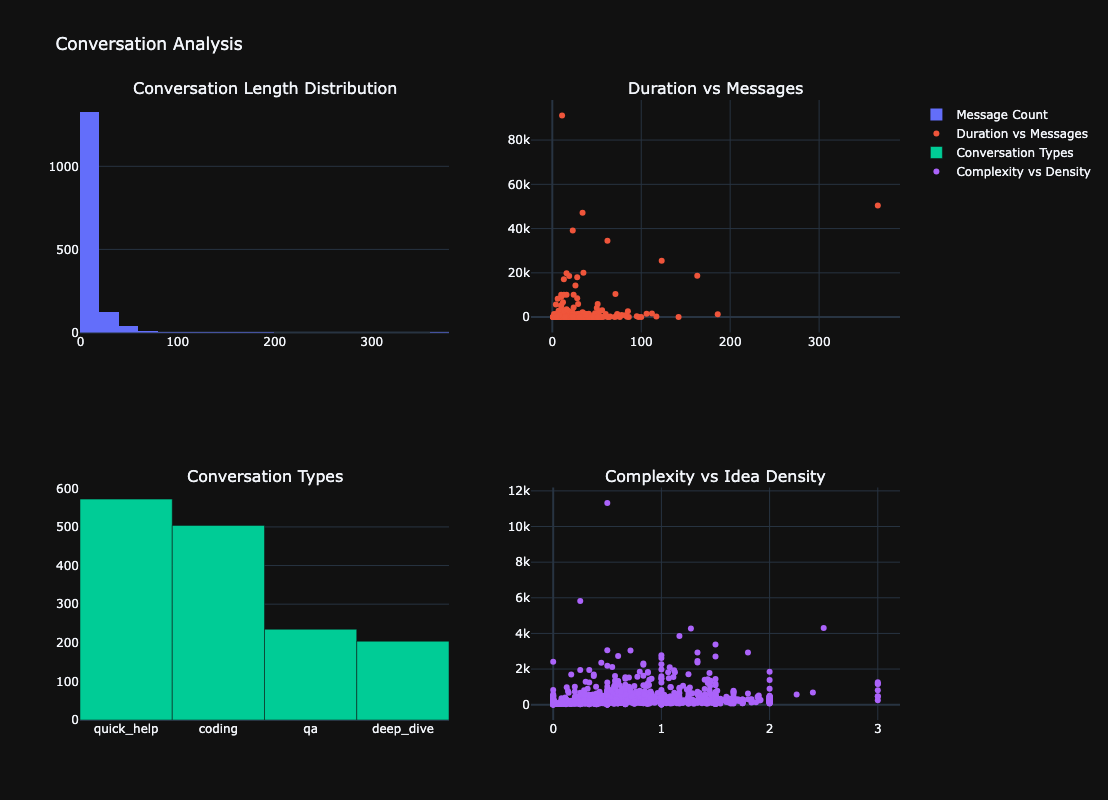

In [10]:
# Conversation lengths and characteristics
print("=== CONVERSATION CHARACTERISTICS ===")
print(f"Average messages per conversation: {conv_features_df['message_count'].mean():.1f}")
print(f"Median messages per conversation: {conv_features_df['message_count'].median():.1f}")
print(f"Average words per conversation: {conv_features_df['total_word_count'].mean():.0f}")
print(f"Average conversation duration: {conv_features_df['duration_minutes'].mean():.1f} minutes")

# Conversation types
print("\n=== CONVERSATION TYPES ===")
conv_type_counts = conv_features_df['conversation_type'].value_counts()
for conv_type, count in conv_type_counts.items():
    print(
        f"{conv_type.replace('_', ' ').title()}: {count:,} conversations ({count / len(conv_features_df) * 100:.1f}%)")

# Visualize conversation characteristics
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Conversation Length Distribution', 'Duration vs Messages', 'Conversation Types',
                    'Complexity vs Idea Density']
)

# Conversation length distribution
fig.add_trace(
    go.Histogram(x=conv_features_df['message_count'], name='Message Count', nbinsx=20),
    row=1, col=1
)

# Duration vs Messages scatter
fig.add_trace(
    go.Scatter(x=conv_features_df['message_count'], y=conv_features_df['duration_minutes'],
               mode='markers', name='Duration vs Messages'),
    row=1, col=2
)

# Conversation types
fig.add_trace(
    go.Bar(x=conv_type_counts.index, y=conv_type_counts.values, name='Conversation Types'),
    row=2, col=1
)

# Complexity vs. Idea Density
fig.add_trace(
    go.Scatter(x=conv_features_df['complexity_score'], y=conv_features_df['idea_density'],
               mode='markers', name='Complexity vs Density'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Conversation Analysis")
fig.show()

## 🔍 Content Analysis

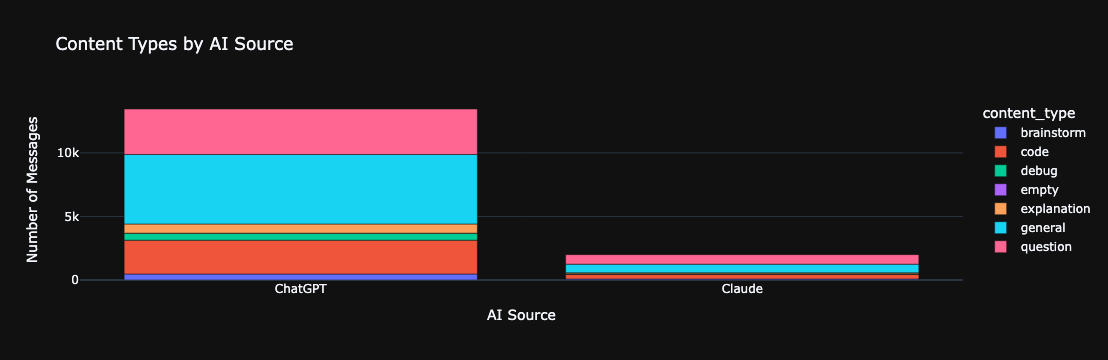

=== CONTENT CHARACTERISTICS BY AI SOURCE ===

ChatGPT:
  Code messages: 19.8%
  URL messages: 13.6%
  Question messages: 34.7%

Claude:
  Code messages: 18.2%
  URL messages: 8.6%
  Question messages: 46.9%


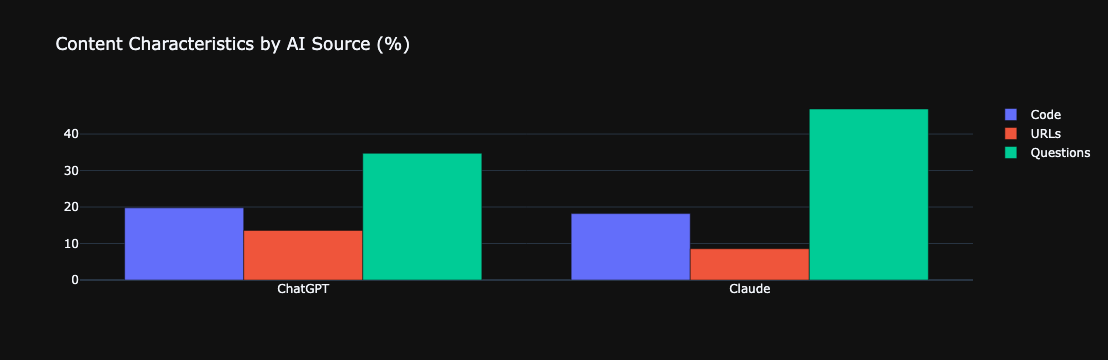

In [11]:
# Content analysis by AI source
content_by_ai = combined_df.groupby(['source_ai', 'content_type']).size().reset_index(name='count')
content_pivot = content_by_ai.pivot(index='source_ai', columns='content_type', values='count').fillna(0)

# Normalize by percentage
content_pivot_pct = content_pivot.div(content_pivot.sum(axis=1), axis=0) * 100

fig = px.bar(content_by_ai, x='source_ai', y='count', color='content_type',
             title='Content Types by AI Source',
             labels={'source_ai': 'AI Source', 'count': 'Number of Messages'})
fig.show()

# Code vs non-code analysis
code_analysis = combined_df.groupby('source_ai').agg({
    'has_code': 'sum',
    'has_urls': 'sum',
    'has_questions': 'sum',
    'message_id': 'count'
}).reset_index()

code_analysis['code_percentage'] = (code_analysis['has_code'] / code_analysis['message_id']) * 100
code_analysis['url_percentage'] = (code_analysis['has_urls'] / code_analysis['message_id']) * 100
code_analysis['question_percentage'] = (code_analysis['has_questions'] / code_analysis['message_id']) * 100

print("=== CONTENT CHARACTERISTICS BY AI SOURCE ===")
for _, row in code_analysis.iterrows():
    print(f"\n{row['source_ai']}:")
    print(f"  Code messages: {row['code_percentage']:.1f}%")
    print(f"  URL messages: {row['url_percentage']:.1f}%")
    print(f"  Question messages: {row['question_percentage']:.1f}%")

# Visualize content characteristics
fig = go.Figure()
fig.add_trace(go.Bar(name='Code', x=code_analysis['source_ai'], y=code_analysis['code_percentage']))
fig.add_trace(go.Bar(name='URLs', x=code_analysis['source_ai'], y=code_analysis['url_percentage']))
fig.add_trace(go.Bar(name='Questions', x=code_analysis['source_ai'], y=code_analysis['question_percentage']))
fig.update_layout(title='Content Characteristics by AI Source (%)', barmode='group')
fig.show()

## 😊 Sentiment Analysis

=== SENTIMENT ANALYSIS ===
                    sentiment_score             
                               mean    std count
source_ai role                                  
ChatGPT   Assistant           0.672  0.464  6133
          Tool                0.353  0.514  2130
          User                0.185  0.390  5190
Claude    Assistant           0.732  0.449   997
          User                0.174  0.352   998


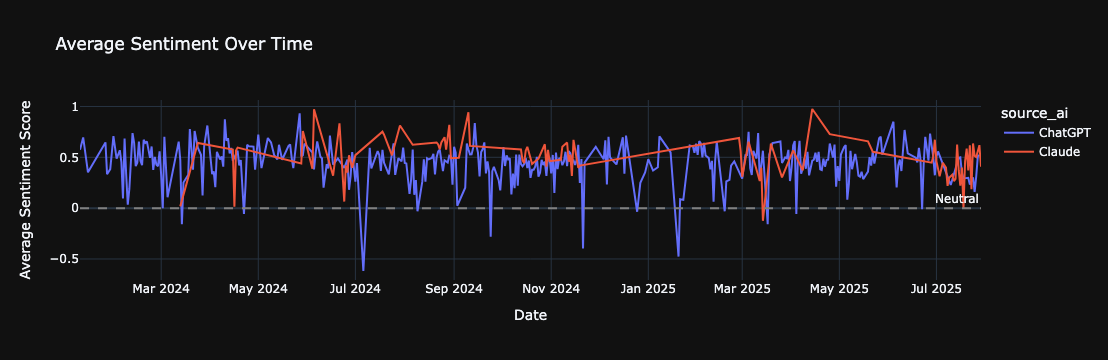

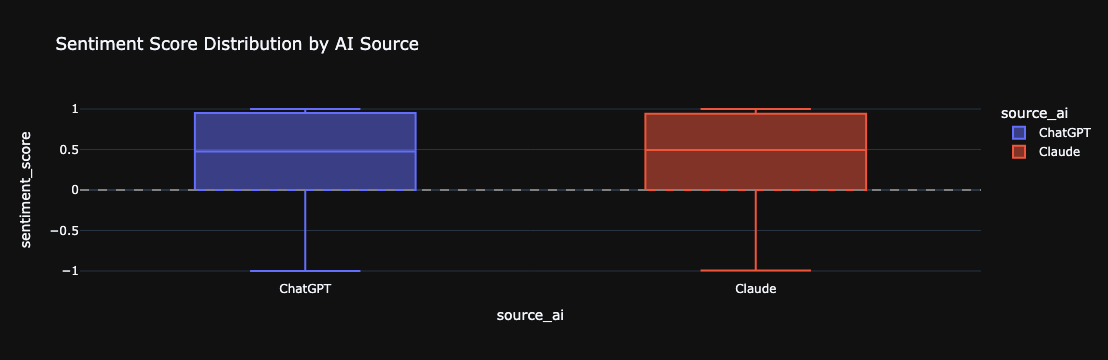

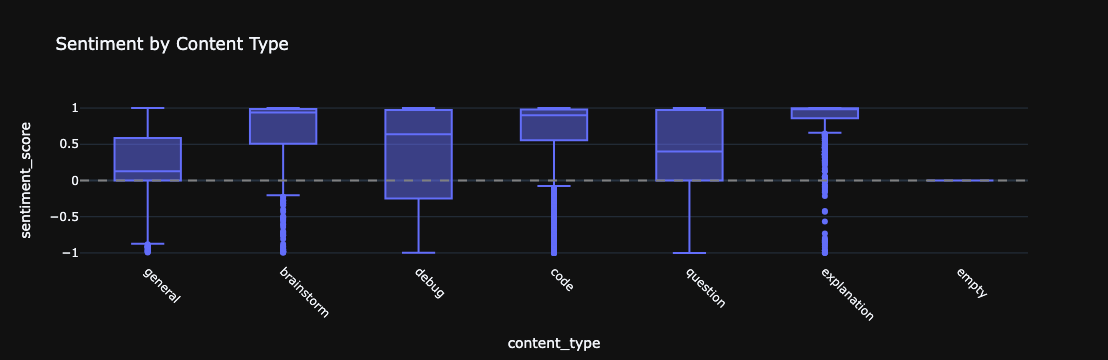

In [14]:
# Sentiment analysis by AI and content type
sentiment_stats = combined_df.groupby(['source_ai', 'role']).agg({
    'sentiment_score': ['mean', 'std', 'count']
}).round(3)

print("=== SENTIMENT ANALYSIS ===")
print(sentiment_stats)

# Sentiment over time
combined_df['date'] = combined_df['timestamp'].dt.date
daily_sentiment = combined_df.groupby(['date', 'source_ai'])['sentiment_score'].mean().reset_index()

fig = px.line(daily_sentiment, x='date', y='sentiment_score', color='source_ai',
              title='Average Sentiment Over Time',
              labels={'date': 'Date', 'sentiment_score': 'Average Sentiment Score'})
fig.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Neutral")
fig.show()

# Sentiment distribution by AI source
fig = px.box(combined_df, x='source_ai', y='sentiment_score', color='source_ai',
             title='Sentiment Score Distribution by AI Source')
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.show()

# Sentiment by content type
fig = px.box(combined_df, x='content_type', y='sentiment_score',
             title='Sentiment by Content Type')
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_xaxes(tickangle=45)
fig.show()

## 🏆 Top Insights

In [12]:
# Most productive days
daily_counts = combined_df.groupby(combined_df['timestamp'].dt.date).size()
top_days = daily_counts.nlargest(10)

print("=== TOP 10 MOST ACTIVE DAYS ===")
for date, count in top_days.items():
    print(f"{date}: {count} messages")

# Longest conversations
longest_convs = conv_features_df.nlargest(10, 'message_count')[
    ['title', 'source_ai', 'message_count', 'total_word_count', 'conversation_type']]
print("\n=== TOP 10 LONGEST CONVERSATIONS ===")
for _, conv in longest_convs.iterrows():
    title = conv['title'][:50] + "..." if len(str(conv['title'])) > 50 else conv['title']
    print(f"{title} ({conv['source_ai']})")
    print(f"  {conv['message_count']} messages, {conv['total_word_count']:,} words, type: {conv['conversation_type']}")

# Most complex conversations (high code and question content)
complex_convs = conv_features_df.nlargest(10, 'complexity_score')[
    ['title', 'source_ai', 'complexity_score', 'conversation_type']]
print("\n=== TOP 10 MOST COMPLEX CONVERSATIONS ===")
for _, conv in complex_convs.iterrows():
    title = conv['title'][:50] + "..." if len(str(conv['title'])) > 50 else conv['title']
    print(f"{title} ({conv['source_ai']})")
    print(f"  Complexity: {conv['complexity_score']:.2f}, Type: {conv['conversation_type']}")

=== TOP 10 MOST ACTIVE DAYS ===
2024-06-25: 246 messages
2024-09-11: 219 messages
2025-07-25: 216 messages
2024-10-21: 208 messages
2024-10-28: 193 messages
2024-11-07: 175 messages
2024-10-09: 170 messages
2024-10-27: 158 messages
2025-04-14: 153 messages
2024-10-31: 152 messages

=== TOP 10 LONGEST CONVERSATIONS ===
Performance Conversation Plan (ChatGPT)
  366 messages, 57,432 words, type: deep_dive
Drafting a Living Will and Advance Directives (Claude)
  186 messages, 25,604 words, type: deep_dive
Workflow Integration for Onboarding (ChatGPT)
  163 messages, 94,015 words, type: deep_dive
Parse and build project (ChatGPT)
  142 messages, 6,051 words, type: deep_dive
AI Expert Panel Advancement (ChatGPT)
  123 messages, 44,525 words, type: coding
Sitemap lastmod date errors (ChatGPT)
  117 messages, 26,859 words, type: coding
Simpleminded Robot Strategery (ChatGPT)
  112 messages, 39,024 words, type: deep_dive
Individual Account Request Details (ChatGPT)
  106 messages, 114,256 words

## 🎯 Custom Analysis

Use this section to run your own custom queries and analyses.

In [13]:
# Example: Find all conversations about a specific topic
search_term = "python"  # Change this to search for specific topics

topic_conversations = combined_df[combined_df['content'].str.contains(search_term, case=False, na=False)]
topic_conv_ids = topic_conversations['conversation_id'].unique()

print(f"Found {len(topic_conv_ids)} conversations mentioning '{search_term}'")
print(f"Total messages in these conversations: {len(topic_conversations)}")

# Show some examples
if len(topic_conv_ids) > 0:
    sample_convs = conv_features_df[conv_features_df['conversation_id'].isin(topic_conv_ids)].head(5)
    print(f"\nSample conversations:")
    for _, conv in sample_convs.iterrows():
        title = conv['title'][:60] + "..." if len(str(conv['title'])) > 60 else conv['title']
        print(f"• {title} ({conv['source_ai']}) - {conv['message_count']} messages")

Found 274 conversations mentioning 'python'
Total messages in these conversations: 927

Sample conversations:
• Fishbone Diagram Overview (ChatGPT) - 12 messages
• Field Mapping Tool for Data Integration (Claude) - 8 messages
• None (ChatGPT) - 2 messages
• Resume Conversion for Business Analyst Role (Claude) - 2 messages
• Improving the OpenAPI RAG Tool (Claude) - 14 messages


In [15]:
# Export summary data for external use
summary_data = {
    'total_messages': len(combined_df),
    'total_conversations': len(conv_features_df),
    'ai_sources': list(combined_df['source_ai'].unique()),
    'date_range': {
        'start': combined_df['timestamp'].min().isoformat(),
        'end': combined_df['timestamp'].max().isoformat()
    },
    'content_types': content_counts.to_dict(),
    'avg_sentiment': combined_df['sentiment_score'].mean(),
    'code_percentage': (combined_df['has_code'].sum() / len(combined_df)) * 100
}

print("=== EXPORTABLE SUMMARY ===")
print(json.dumps(summary_data, indent=2, default=str))

# Optionally save to a file
# with open('chat_analysis_summary.json', 'w') as f:
#     json.dump(summary_data, f, indent=2, default=str)
# print("Summary saved to chat_analysis_summary.json")

=== EXPORTABLE SUMMARY ===
{
  "total_messages": 15448,
  "total_conversations": 1515,
  "ai_sources": [
    "ChatGPT",
    "Claude"
  ],
  "date_range": {
    "start": "2024-01-10T19:24:41.649415+00:00",
    "end": "2025-07-29T01:07:01.715269+00:00"
  },
  "content_types": {
    "general": 6143,
    "question": 4327,
    "code": 3023,
    "explanation": 807,
    "debug": 594,
    "brainstorm": 553,
    "empty": 1
  },
  "avg_sentiment": 0.4357561690833765,
  "code_percentage": 19.568876229932677
}


## 🚀 Phase 2 Setup

In [16]:
from phase2_helpers import create_gap_analysis_views, upsert_code_snippets, build_simple_topics, search_by_text

# Ensure views exist for analyses
create_gap_analysis_views(str(db_path))
print("✅ Gap-analysis SQL views ready: view_confusion_signals, view_conversation_confusion")

# Optionally (re)build code snippets and topics; safe to re-run
try:
    inserted = upsert_code_snippets(str(db_path), limit=None)
    print(f"✅ Code snippets upserted: {inserted}")
except Exception as e:
    print(f"⚠️ Code snippet extraction skipped/failed: {e}")

try:
    n_topics = build_simple_topics(str(db_path), n_clusters=12)
    print(f"✅ Topics built: {n_topics} (None means skipped due to deps/data)")
except Exception as e:
    print(f"⚠️ Topics build skipped/failed: {e}")

✅ Database connection closed
🎉 Analysis complete! Feel free to modify and extend this notebook for your specific needs.


## 🧩 Code Pattern Library — Explore Snippets

In [ ]:
import json as _json

# Verify table exists
_tables = set(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)['name'])
if 'code_snippets' not in _tables:
    print("ℹ️ code_snippets table not found. Run upsert_code_snippets() first.")
else:
    df_snips = pd.read_sql_query(
        """
        SELECT id, source_ai, conversation_id, snippet_type, language,
               substr(context_preview,1,200) AS preview,
               length(code) AS code_len,
               tags
        FROM code_snippets
        ORDER BY id DESC
        LIMIT 200
        """, conn
    )
    # Parse tags JSON if present
    df_snips['tag_list'] = df_snips['tags'].apply(lambda t: _json.loads(t) if t else [])
    display(df_snips.head(10))
    print("Top languages:\n", df_snips['language'].value_counts().head(10))
    print("Top snippet types:\n", df_snips['snippet_type'].value_counts())

## 🗂️ Topics Overview

In [ ]:
_tables = set(pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)['name'])
if 'topics' not in _tables:
    print("ℹ️ topics table not found. Run build_simple_topics() first.")
else:
    df_topics = pd.read_sql_query(
        "SELECT topic_id, top_keywords, representative_message_id, size FROM topics ORDER BY size DESC",
        conn
    )
    display(df_topics.head(10))
    # Optional: bar chart of topic sizes
    fig = px.bar(df_topics, x='topic_id', y='size', title='Topic Sizes')
    fig.show()

    # Join representative messages
    rep_ids = tuple(df_topics['representative_message_id'].dropna().unique())
    if len(rep_ids) > 0:
        q = f"SELECT message_id, content FROM raw_conversations WHERE message_id IN {rep_ids}"
        df_rep = pd.read_sql_query(q, conn)
        display(df_rep.head(10))

## 📉 Learning Gap Analysis

In [ ]:
try:
    df_conf_sig = pd.read_sql_query(
        "SELECT * FROM view_confusion_signals ORDER BY sentiment_score ASC LIMIT 200",
        conn
    )
    df_conv_conf = pd.read_sql_query(
        "SELECT * FROM view_conversation_confusion ORDER BY high_question_msgs DESC, avg_sentiment ASC LIMIT 100",
        conn
    )
    display(df_conf_sig.head(10))
    display(df_conv_conf.head(10))

    # Join titles for context
    df_conv_conf_ctx = df_conv_conf.merge(
        conv_features_df[['conversation_id', 'title', 'source_ai']], on='conversation_id', how='left'
    )
    fig = px.scatter(df_conv_conf_ctx, x='avg_questions', y='avg_sentiment', size='high_question_msgs',
                     color='source_ai', hover_data=['title', 'conversation_id'],
                     title='Conversations: Questions vs Sentiment (bubble=size of high-question msgs)')
    fig.add_hline(y=0, line_dash='dash', line_color='gray')
    fig.show()
except Exception as e:
    print(f"⚠️ Gap analysis views not available: {e}")

## 🔎 Text Semantic Search

In [ ]:
query = "vector database migration"  # adjust your query
try:
    results = search_by_text(str(db_path), query, limit=5)
    for i, r in enumerate(results, 1):
        preview = (r.get('content','')[:200] + '...') if r.get('content') and len(r['content'])>200 else r.get('content','')
        print(f"{i}. conv={r.get('conversation_id')} role={r.get('role')} ai={r.get('source_ai')}\n   {preview}\n")
except Exception as e:
    print(f"⚠️ Semantic search unavailable: {e}")

## 🤝 AI Assistant Optimization — Comparisons and Routing Guidance

In [ ]:
# Comparative metrics by source_ai
comp = combined_df.groupby('source_ai').agg(
    avg_sentiment=('sentiment_score', 'mean'),
    complexity_mean=('complexity', 'mean') if 'complexity' in combined_df.columns else ('word_count','mean'),
    idea_density_mean=('idea_density', 'mean') if 'idea_density' in combined_df.columns else ('word_count','mean'),
    has_code_pct=('has_code', lambda s: 100*s.sum()/len(s)),
    has_questions_pct=('has_questions', lambda s: 100*s.sum()/len(s))
).reset_index()
try:
    display(comp)
    # Simple bar charts
    fig = px.bar(comp, x='source_ai', y=['avg_sentiment','has_code_pct','has_questions_pct'], barmode='group',
                 title='Assistant Comparison: Sentiment and Prevalence Metrics')
    fig.show()
except Exception:
    print(comp)

### Routing Guidance (Summary)
Based on observed metrics above:
- Prefer the assistant with higher avg_sentiment for exploratory Q&A and brainstorming.
- Prefer the assistant with higher has_code_pct for coding-heavy tasks or stack traces.
- Prefer the assistant with higher has_questions_pct when you want the AI to ask clarifying questions.

Document specific takeaways here after running on your dataset.

## 🔧 Database Connection Cleanup

In [ ]:
# Close database connection
conn.close()
print("✅ Database connection closed")
print("🎉 Analysis complete! Feel free to modify and extend this notebook for your specific needs.")